In [1]:
import os
import zipfile
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

np.random.seed(42)



# Définir les chemins des dossiers
input_folder = "data"
output_folder = "data_part2_E1"

# Créez le dossier de sortie s'il n'existe pas
os.makedirs(output_folder, exist_ok=True)

# Parcourir tous les fichiers dans le dossier "data"
for i, zip_file_name in enumerate(os.listdir(input_folder)):
    if zip_file_name.endswith(".zip"):
        zip_path = os.path.join(input_folder, zip_file_name)
        # Numéro du dossier extrait du nom du fichier ZIP
        print(zip_path)

        target_file_name = f"S{i+1}_A1_E1.mat"
            
            # Ouvrir le fichier ZIP
        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            # Vérifier si le fichier cible est dans l'archive
            if target_file_name in zip_file.namelist():
                # Extraire le fichier cible dans le dossier de sortie
                zip_file.extract(target_file_name, output_folder)
                print(f"Extracted: {target_file_name} from {zip_file_name}")
            else:
                print(f"File {target_file_name} not found in {zip_file_name}")


data/s1.zip
Extracted: S1_A1_E1.mat from s1.zip
data/s2.zip
Extracted: S2_A1_E1.mat from s2.zip
data/s3.zip
Extracted: S3_A1_E1.mat from s3.zip
data/s4.zip
Extracted: S4_A1_E1.mat from s4.zip
data/s5.zip
Extracted: S5_A1_E1.mat from s5.zip
data/s6.zip
Extracted: S6_A1_E1.mat from s6.zip
data/s7.zip
Extracted: S7_A1_E1.mat from s7.zip
data/s8.zip
Extracted: S8_A1_E1.mat from s8.zip
data/s9.zip
Extracted: S9_A1_E1.mat from s9.zip
data/s10.zip
Extracted: S10_A1_E1.mat from s10.zip
data/s11.zip
Extracted: S11_A1_E1.mat from s11.zip
data/s12.zip
Extracted: S12_A1_E1.mat from s12.zip
data/s13.zip
Extracted: S13_A1_E1.mat from s13.zip
data/s14.zip
Extracted: S14_A1_E1.mat from s14.zip
data/s15.zip
Extracted: S15_A1_E1.mat from s15.zip
data/s16.zip
Extracted: S16_A1_E1.mat from s16.zip
data/s17.zip
Extracted: S17_A1_E1.mat from s17.zip
data/s18.zip
Extracted: S18_A1_E1.mat from s18.zip
data/s19.zip
Extracted: S19_A1_E1.mat from s19.zip
data/s20.zip
Extracted: S20_A1_E1.mat from s20.zip
data/s2

In [2]:
# UTILS

def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    print('Number of samples', n_samples)
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

# 1. Preprocess and visualize features

In [3]:
E1_data_path = 'data_part2_E1'

In [4]:
# extract features for 27 subjects and store features and labels in dictionaries

all_datasets = {}
all_labels = {}

for i in range (27):
    print(f'SUBJECT {i+1}')
    mat_path = os.path.join(E1_data_path, f'S{i+1}_A1_E1.mat')
    mat = loadmat(mat_path)

    emg = mat["emg"]
    print("EMG data dimension: {}".format(emg.shape))
    print("EMG data type: {}".format(type(emg)))

    stimulus = mat['restimulus']
    repetition = mat['rerepetition']

    n_stimuli = len(np.unique(stimulus)) - 1 # -1 because 0 is the resting condition
    print('Number of stimuli', n_stimuli)
    n_repetitions = len(np.unique(repetition)) - 1 # -1 because 0 is not a repetition
    print('Number of repetitions', n_repetitions)

    mov_mean_length = 25
    mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length
    
    #initializing the data structure
    emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
    emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
    
    for stimuli_idx in range(n_stimuli):
        for repetition_idx in range(n_repetitions):
            idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
            emg_windows[stimuli_idx][repetition_idx] = emg[idx, :]
            emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

    # Define the features 
    
    # Mean absolute value (MAV)
    mav = lambda x: np.mean(np.abs(x), axis=0)
    # Standard Deviation (STD)
    std = lambda x: np.std(x, axis=0)
    # Maximum absolute Value (MaxAV)
    maxav = lambda x: np.max(np.abs(x), axis=0)
    # Root mean square (RMS)
    rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
    # Waveform length (WL)
    wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
    # Slope sign changes (SSC)
    ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)
    
    #Feel free to add more features, e.g. frequency domain features. (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307)
    
    
    dataset, labels = build_dataset_from_ninapro(
        emg=emg,
        stimulus=stimulus,
        repetition=repetition,
        features=[mav, std, maxav, rms, wl, ssc]
    )
    
    all_datasets[f"dataset_{i + 1}"] = dataset
    all_labels[f"labels_{i + 1}"] = labels
    
    print(f"dataset dimension: {dataset.shape}")
    print(f"labels dimension: {labels.shape}")



SUBJECT 1
EMG data dimension: (101014, 10)
EMG data type: <class 'numpy.ndarray'>
Number of stimuli 12
Number of repetitions 10
Number of samples 120
dataset dimension: (120, 60)
labels dimension: (120,)
SUBJECT 2
EMG data dimension: (100686, 10)
EMG data type: <class 'numpy.ndarray'>
Number of stimuli 12
Number of repetitions 10
Number of samples 120
dataset dimension: (120, 60)
labels dimension: (120,)
SUBJECT 3
EMG data dimension: (100720, 10)
EMG data type: <class 'numpy.ndarray'>
Number of stimuli 12
Number of repetitions 10
Number of samples 120
dataset dimension: (120, 60)
labels dimension: (120,)
SUBJECT 4
EMG data dimension: (100835, 10)
EMG data type: <class 'numpy.ndarray'>
Number of stimuli 12
Number of repetitions 10
Number of samples 120
dataset dimension: (120, 60)
labels dimension: (120,)
SUBJECT 5
EMG data dimension: (100894, 10)
EMG data type: <class 'numpy.ndarray'>
Number of stimuli 12
Number of repetitions 10
Number of samples 120
dataset dimension: (120, 60)
label

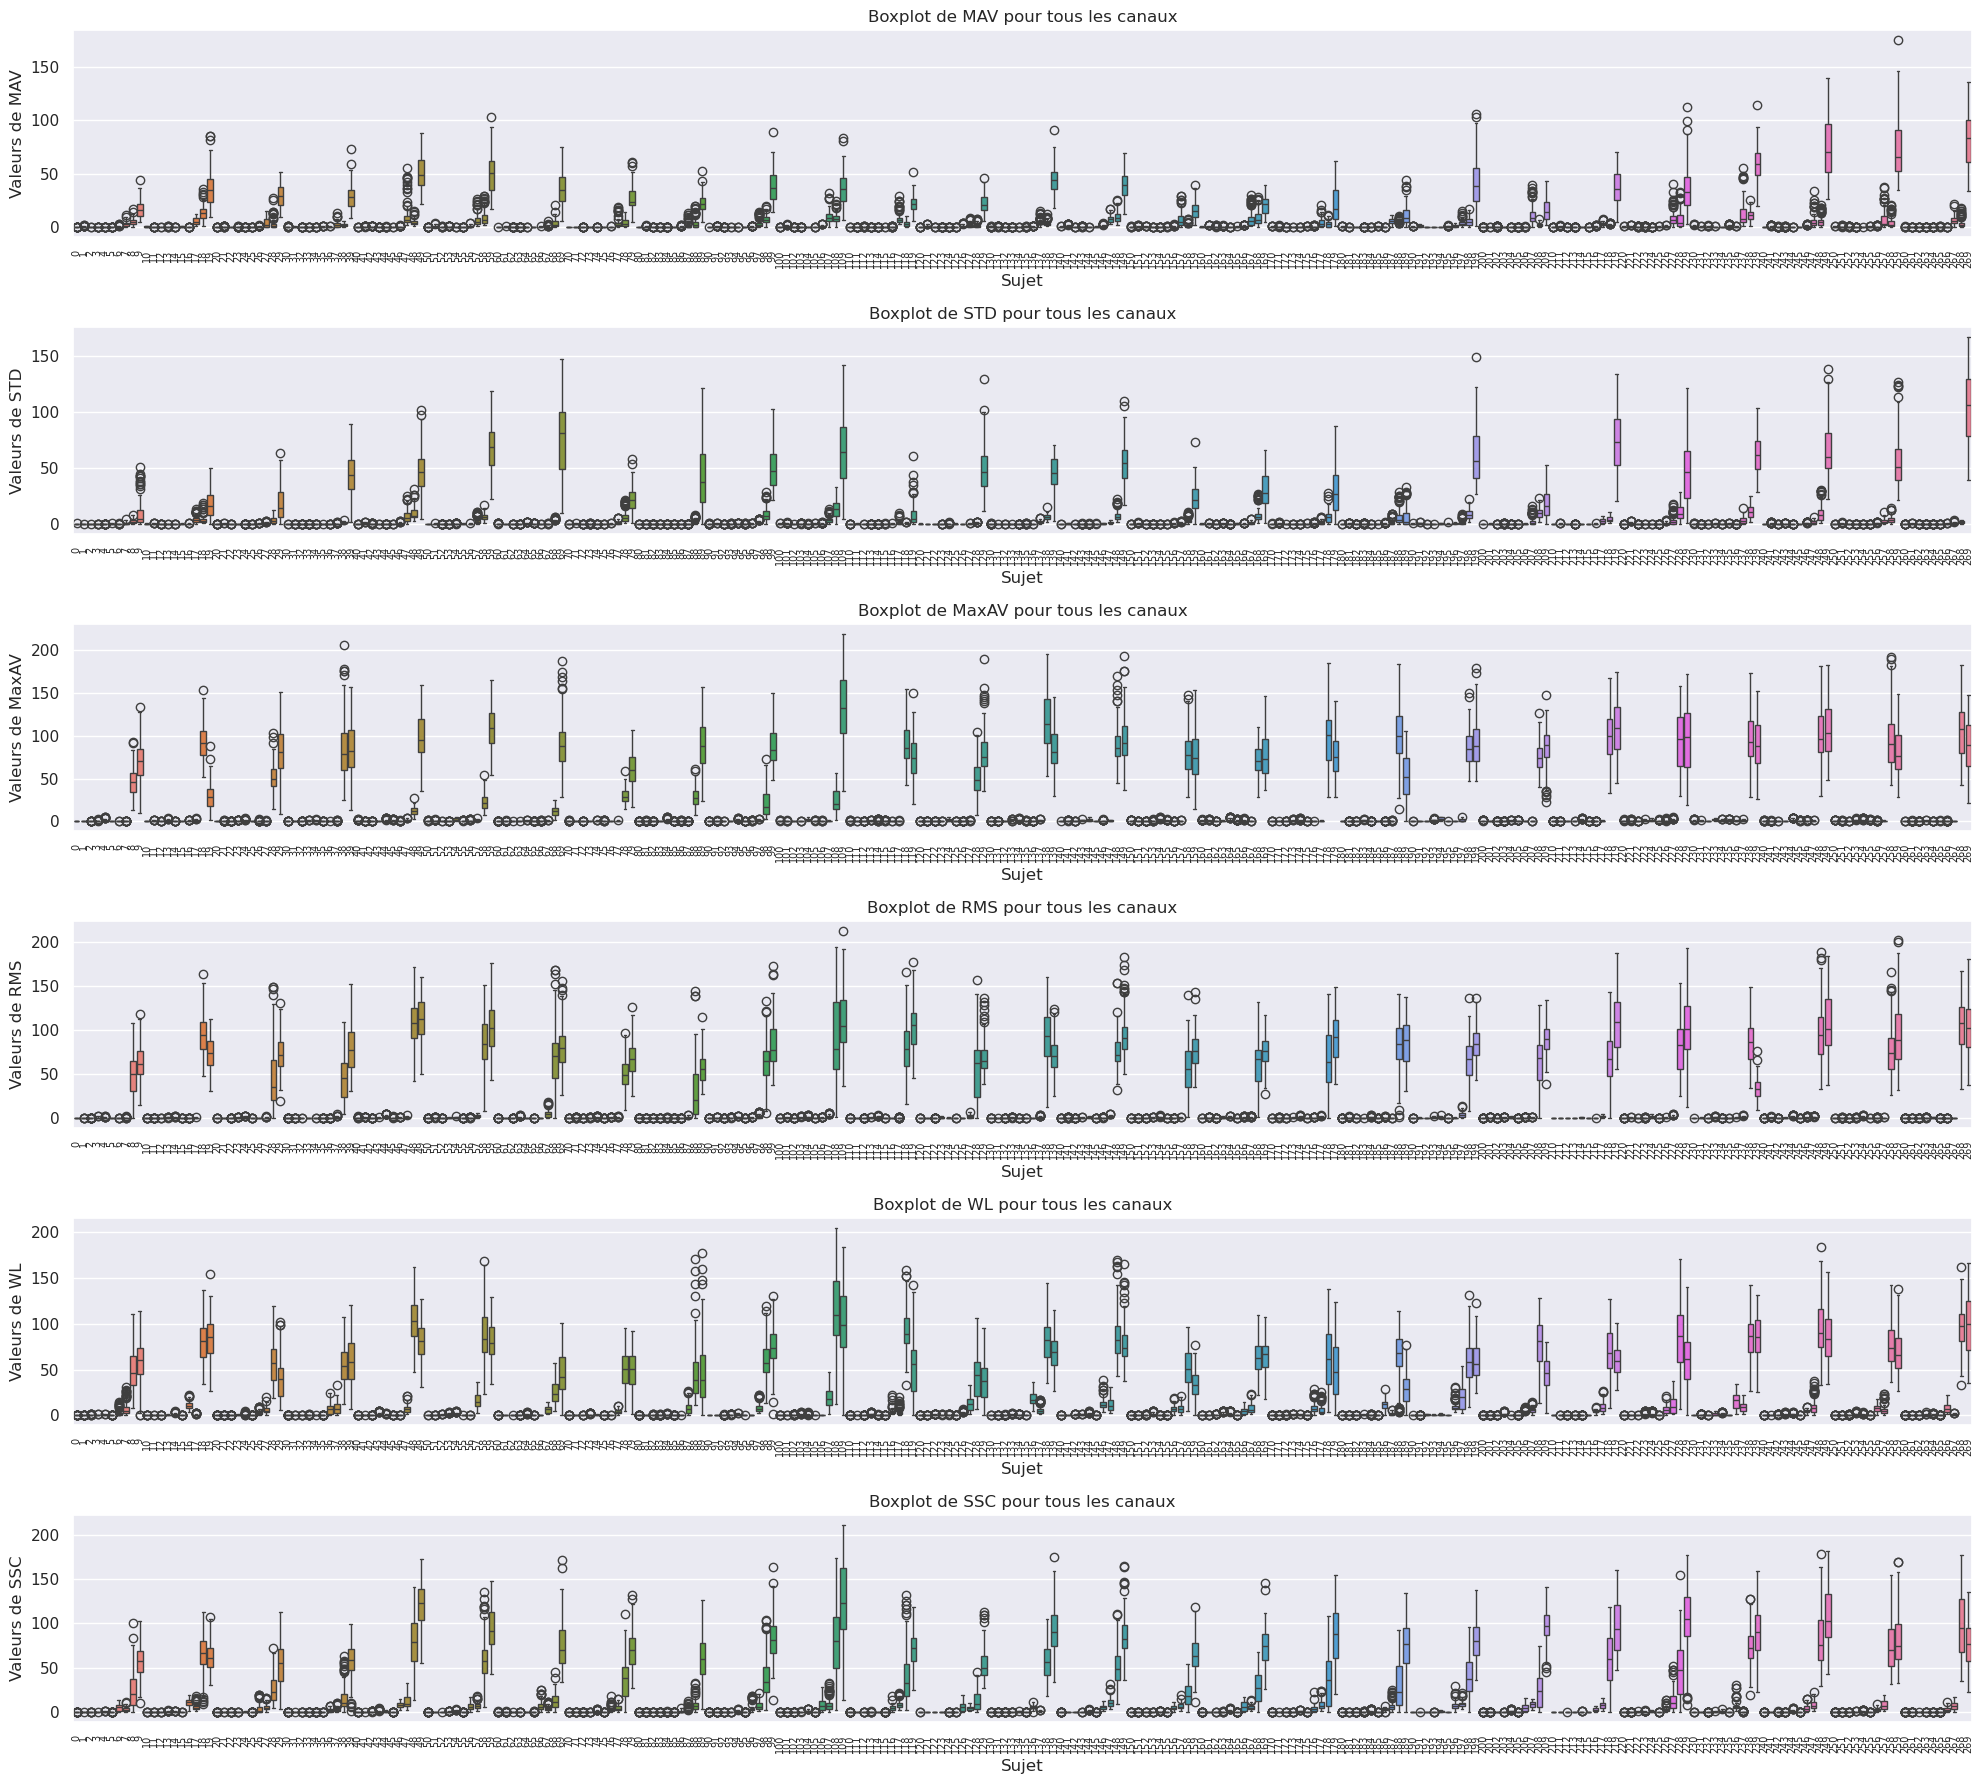

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Nombre de caractéristiques par canal
feature_names = ["MAV", "STD", "MaxAV", "RMS", "WL", "SSC"]

# Nombre de canaux
n_channels = 10

# Organiser les données pour les boxplots
# Extraire les caractéristiques pour tous les sujets et les canaux
all_feature_data = {feature: [] for feature in feature_names}

for subject in range(27):  # Parcourir tous les sujets
    dataset = all_datasets[f"dataset_{subject + 1}"]
    
    # Pour chaque canal (10 canaux) et chaque caractéristique (6 caractéristiques)
    for channel_idx in range(n_channels):
        for feature_idx, feature_name in enumerate(feature_names):
            # Calcul des indices des caractéristiques dans le dataset
            feature_values = dataset[:, channel_idx * len(feature_names) + feature_idx]
            all_feature_data[feature_name].append(feature_values)

# Tracer les boxplots pour chaque caractéristique
plt.figure(figsize=(20, 18))  # Ajuster la taille pour mieux afficher les plots verticaux

for i, feature_name in enumerate(feature_names):
    plt.subplot(6, 1, i + 1)  # 6 lignes et 1 colonne de sous-graphiques
    sns.boxplot(data=all_feature_data[feature_name])
    plt.title(f"Boxplot de {feature_name} pour tous les canaux")
    plt.xlabel("Sujet")
    plt.xticks(rotation=90, fontsize=7)
    plt.ylabel(f"Valeurs de {feature_name}")

plt.tight_layout()
plt.show()


# 2. Train on 26 subjects and test on 1

In [6]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import random

# Randomly select one test subject (out of 27)
test_subject_idx = random.randint(0, 26)  # Random integer between 0 and 26 (inclusive)

# Create the training set by excluding the test subject
train_datasets = []
train_labels = []

for train_subject_idx in range(27):
    if train_subject_idx != test_subject_idx:
        # Aggregate data from the training subjects
        train_datasets.append(all_datasets[f"dataset_{train_subject_idx + 1}"])
        train_labels.append(all_labels[f"labels_{train_subject_idx + 1}"])

# Concatenate data from all training subjects
X_train = np.concatenate(train_datasets, axis=0)
y_train = np.concatenate(train_labels, axis=0)

# Get the test data for the randomly chosen test subject
X_test = all_datasets[f"dataset_{test_subject_idx + 1}"]
y_test = all_labels[f"labels_{test_subject_idx + 1}"]

# Standardize the features (mean=0, std=1) for both training and test data
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_z = scaler.fit_transform(X_train)

# Transform the test data using the same scaler (using fit from the training data)
X_test_z = scaler.transform(X_test)

# Initialize the Gradient Boosting model
gb_clf = GradientBoostingClassifier()

# Train the model on the standardized training data
gb_clf.fit(X_train_z, y_train)

# Make predictions on the standardized test data
y_pred = gb_clf.predict(X_test_z)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)

# Print the performance for the test subject
print(f"Performance on randomly chosen test Subject {test_subject_idx + 1}: {accuracy:.4f}")


Performance on randomly chosen test Subject 27: 0.2417


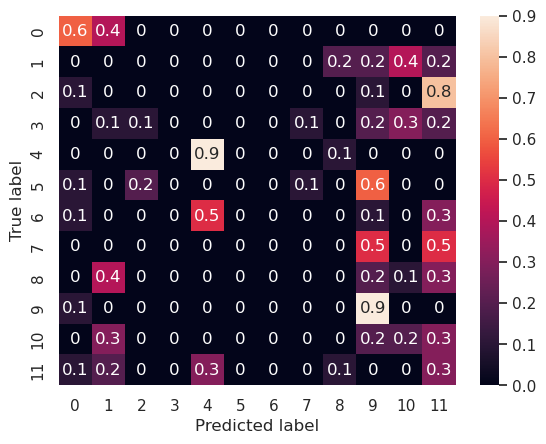

In [7]:
from sklearn.metrics import confusion_matrix

# Create a confusion matrix to visualize the performance of the classification
# The confusion matrix shows the true vs predicted labels
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label");

# 3. Cross validation

Training and testing for fold 1 (Test Subject: 1)
Accuracy for fold 1: 0.3167
Training and testing for fold 2 (Test Subject: 2)
Accuracy for fold 2: 0.1167
Training and testing for fold 3 (Test Subject: 3)
Accuracy for fold 3: 0.4250
Training and testing for fold 4 (Test Subject: 4)
Accuracy for fold 4: 0.2917
Training and testing for fold 5 (Test Subject: 5)
Accuracy for fold 5: 0.3917
Training and testing for fold 6 (Test Subject: 6)
Accuracy for fold 6: 0.3083
Training and testing for fold 7 (Test Subject: 7)
Accuracy for fold 7: 0.3000
Training and testing for fold 8 (Test Subject: 8)
Accuracy for fold 8: 0.3750
Training and testing for fold 9 (Test Subject: 9)
Accuracy for fold 9: 0.1917
Training and testing for fold 10 (Test Subject: 10)
Accuracy for fold 10: 0.3917
Training and testing for fold 11 (Test Subject: 11)
Accuracy for fold 11: 0.3083
Training and testing for fold 12 (Test Subject: 12)
Accuracy for fold 12: 0.3417
Training and testing for fold 13 (Test Subject: 13)
Acc

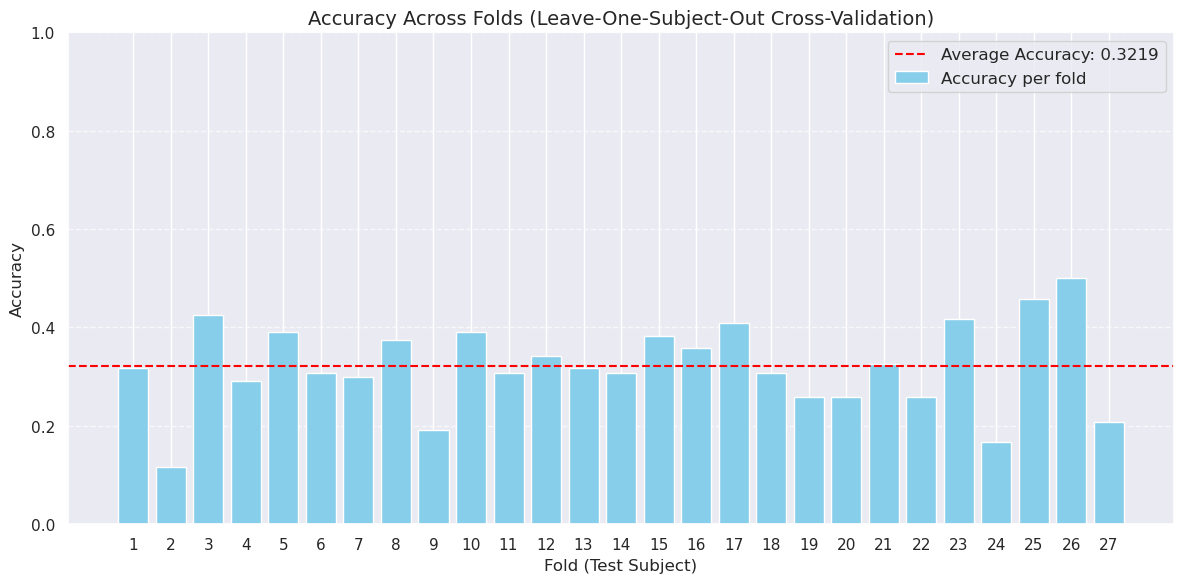

In [8]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Initialize the classifier
gb_clf = GradientBoostingClassifier()

# Store performance results for each fold
performances = []

# Loop through all subjects (27 subjects)
for test_subject_idx in range(27):
    print(f"Training and testing for fold {test_subject_idx + 1} (Test Subject: {test_subject_idx + 1})")
    
    # Create the training set by excluding the current test subject
    train_datasets = []
    train_labels = []
    
    for train_subject_idx in range(27):
        if train_subject_idx != test_subject_idx:
            # Aggregate data from all subjects except the test subject
            train_datasets.append(all_datasets[f"dataset_{train_subject_idx + 1}"])
            train_labels.append(all_labels[f"labels_{train_subject_idx + 1}"])
    
    # Concatenate data from all training subjects
    X_train = np.concatenate(train_datasets, axis=0)
    y_train = np.concatenate(train_labels, axis=0)
    
    # Get the test data for the current test subject
    X_test = all_datasets[f"dataset_{test_subject_idx + 1}"]
    y_test = all_labels[f"labels_{test_subject_idx + 1}"]
    
    # Standardize the features (mean=0, std=1) for both training and test data
    scaler = StandardScaler()
    
    # Fit the scaler on the training data and transform it
    X_train_z = scaler.fit_transform(X_train)
    
    # Transform the test data using the same scaler
    X_test_z = scaler.transform(X_test)
    
    # Train the model on the standardized training data
    gb_clf.fit(X_train_z, y_train)
    
    # Make predictions on the standardized test data
    y_pred = gb_clf.predict(X_test_z)
    
    # Evaluate the model's performance for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    performances.append(accuracy)

    # Print the performance for the current fold
    print(f"Accuracy for fold {test_subject_idx + 1}: {accuracy:.4f}")
    
# Calculate and print the average accuracy across all folds
average_accuracy = np.mean(performances)
print(f"\nAverage classification accuracy across all folds: {average_accuracy:.4f}")

import matplotlib.pyplot as plt

# Number of folds (27 subjects)
folds = np.arange(1, 28)

# Plot the accuracies for each fold
plt.figure(figsize=(12, 6))
plt.bar(folds, performances, color='skyblue', label='Accuracy per fold')

# Plot the average accuracy as a horizontal line
plt.axhline(y=average_accuracy, color='red', linestyle='--', label=f'Average Accuracy: {average_accuracy:.4f}')

# Add labels and title
plt.xlabel('Fold (Test Subject)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Across Folds (Leave-One-Subject-Out Cross-Validation)', fontsize=14)
plt.xticks(folds)  # Ensure each fold is labeled
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


# Cross validation to test the effect of changing the training set size

Number of Training Subjects: 1, Accuracy: 0.0000
Number of Training Subjects: 2, Accuracy: 0.1833
Number of Training Subjects: 3, Accuracy: 0.1417
Number of Training Subjects: 4, Accuracy: 0.1250
Number of Training Subjects: 5, Accuracy: 0.1583
Number of Training Subjects: 6, Accuracy: 0.1667
Number of Training Subjects: 7, Accuracy: 0.1750
Number of Training Subjects: 8, Accuracy: 0.1417
Number of Training Subjects: 9, Accuracy: 0.1250
Number of Training Subjects: 10, Accuracy: 0.1500
Number of Training Subjects: 11, Accuracy: 0.1583
Number of Training Subjects: 12, Accuracy: 0.2083
Number of Training Subjects: 13, Accuracy: 0.1750
Number of Training Subjects: 14, Accuracy: 0.1667
Number of Training Subjects: 15, Accuracy: 0.2250
Number of Training Subjects: 16, Accuracy: 0.2583
Number of Training Subjects: 17, Accuracy: 0.2083
Number of Training Subjects: 18, Accuracy: 0.1917
Number of Training Subjects: 19, Accuracy: 0.2333
Number of Training Subjects: 20, Accuracy: 0.2167
Number of

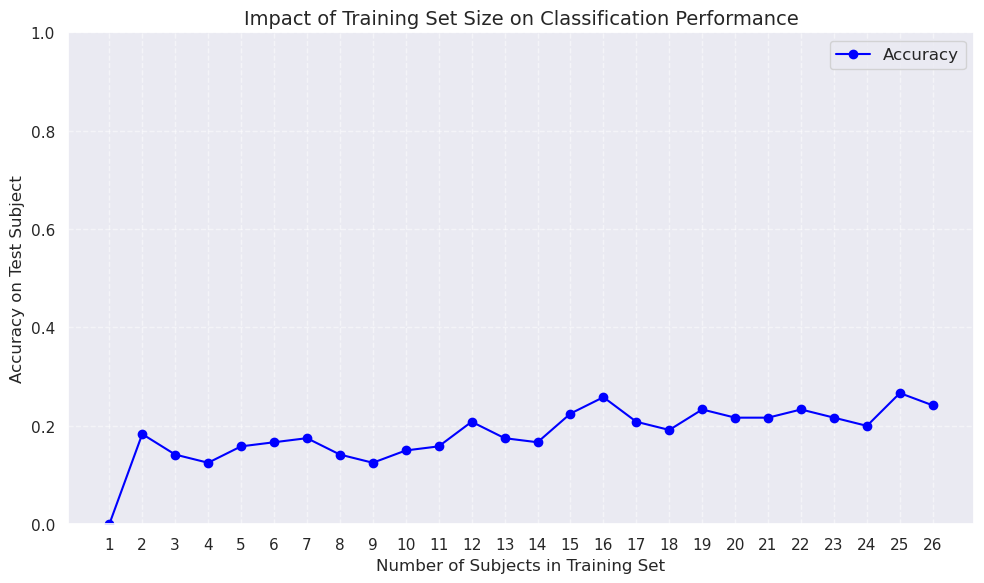

In [9]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Fixed test subject (e.g., Subject 27)
test_subject_idx = 26  

# Get the test data
X_test = all_datasets[f"dataset_{test_subject_idx + 1}"]
y_test = all_labels[f"labels_{test_subject_idx + 1}"]

# Initialize arrays to store results
num_train_subjects = []
performances = []

# Loop to incrementally add subjects to the training set
for train_subject_count in range(1, 27):  # From 1 to 26 subjects
    # Aggregate data from the first `train_subject_count` subjects
    train_datasets = []
    train_labels = []
    
    for train_subject_idx in range(train_subject_count):
        train_datasets.append(all_datasets[f"dataset_{train_subject_idx + 1}"])
        train_labels.append(all_labels[f"labels_{train_subject_idx + 1}"])
    
    # Concatenate the training data
    X_train = np.concatenate(train_datasets, axis=0)
    y_train = np.concatenate(train_labels, axis=0)
    
    # Standardize the features (mean=0, std=1) for both training and test data
    scaler = StandardScaler()
    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)
    
    # Initialize the classifier
    gb_clf = GradientBoostingClassifier()
    
    # Train the model
    gb_clf.fit(X_train_z, y_train)
    
    # Evaluate the model on the fixed test subject
    y_pred = gb_clf.predict(X_test_z)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store the results
    num_train_subjects.append(train_subject_count)
    performances.append(accuracy)

    print(f"Number of Training Subjects: {train_subject_count}, Accuracy: {accuracy:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_train_subjects, performances, marker='o', color='blue', label='Accuracy')
plt.title('Impact of Training Set Size on Classification Performance', fontsize=14)
plt.xlabel('Number of Subjects in Training Set', fontsize=12)
plt.ylabel('Accuracy on Test Subject', fontsize=12)
plt.xticks(range(1, 27))  # Label each training size
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.grid(alpha=0.5, linestyle='--')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
